In [43]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.stats import ks_2samp, mannwhitneyu, wasserstein_distance, norm
from pathlib import Path

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


# Training Dataset vs VAE-Generated Tags Comparison

This notebook compares the original training dataset with VAE-generated tags dataset to validate the generation quality and assess how well the VAE preserves the statistical properties of the original data.


## Load and Prepare Datasets


In [44]:

# Load training dataset
df_train = pd.read_csv("../data/musiccaps_tags_to_description_dataset.csv")
df_train = df_train.reset_index(drop=True)
df_train = df_train.fillna('')

# Parse tag strings to lists
df_train['aspect_list'] = df_train['aspect_list'].apply(lambda x: x.split(', ') if isinstance(x, str) and x else [])
df_train['instrument_tags'] = df_train['instrument_tags'].apply(lambda x: x.split(', ') if isinstance(x, str) and x else [])
df_train['genre_tags'] = df_train['genre_tags'].apply(lambda x: x.split(', ') if isinstance(x, str) and x else [])
df_train['mood_tags'] = df_train['mood_tags'].apply(lambda x: x.split(', ') if isinstance(x, str) and x else [])
df_train['tempo_tags'] = df_train['tempo_tags'].apply(lambda x: x.split(', ') if isinstance(x, str) and x else [])

print("Training Dataset Loaded")
print(f"  Shape: {df_train.shape}")
print(f"  Sample row:")
print(df_train.iloc[0])


Training Dataset Loaded
  Shape: (1958, 6)
  Sample row:
caption            The low quality recording features a ballad so...
aspect_list        [ballad, soulful, mellow piano melody, sad, su...
tempo_tags                                                        []
genre_tags                                         [ballad, soulful]
mood_tags                                 [mellow piano melody, sad]
instrument_tags                           [sustained strings melody]
Name: 0, dtype: object


In [45]:
KNOWN_TAGS = json.load(open("../data/concepts_to_tags.json", "r"))

# Reverse map for easy lookup (tag -> category)
TAG_TO_CATEGORY = {}
for cat, tags in KNOWN_TAGS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat


In [46]:
# Parse tags into categories
def parse_tags(tags):
    return pd.Series({
        'genre_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'genre'],
        'mood_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'mood'],
        'instrument_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'instrument'],
        'tempo_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'tempo']
    })

In [47]:

# Load VAE-generated dataset
df_vae = pd.read_csv("../data/vae_mtg_tags/all.csv")
df_vae = df_vae.reset_index(drop=True)
df_vae = df_vae.fillna('')

# Parse tag strings and list representations
df_vae['aspect_list'] = df_vae['aspect_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
tag_categories = df_vae['aspect_list'].apply(parse_tags)
df_vae = pd.concat([df_vae, tag_categories], axis=1)

print("\nVAE-Generated Dataset Loaded")
print(f"  Shape: {df_vae.shape}")
print(f"  Unique temperatures: {df_vae['temperature'].unique()}")
print(f"  Sample row:")
print(df_vae.iloc[0])



VAE-Generated Dataset Loaded
  Shape: (10039, 12)
  Unique temperatures: [0.5  1.25 1.5  0.8  1.  ]
  Sample row:
original_aspect_list         ['drums', 'bass', 'guitar', 'funk', 'strings',...
aspect_list                  [dreamy, electric guitar, groovy, keyboard, r&...
generated_tempo_tags                                                ['groovy']
generated_genre_tags                                           ['r&b', 'soul']
generated_mood_tags                                  ['dreamy', 'sentimental']
generated_instrument_tags                                  ['electric guitar']
temperature                                                                0.5
id                                            d20e3f1197ddb840911be5b80501c9a2
genre_tags                                                         [r&b, soul]
mood_tags                                                [dreamy, sentimental]
instrument_tags                                    [electric guitar, keyboard]
tempo_tags      

In [48]:

# For easier comparison, focus on a single temperature (use 1.0 as baseline)
df_vae_baseline = df_vae[df_vae['temperature'] == 1.0].reset_index(drop=True)

print(f"\nUsing VAE dataset at temperature=1.0")
print(f"  Shape: {df_vae_baseline.shape}")



Using VAE dataset at temperature=1.0
  Shape: (2005, 12)


## Compute Tag Distribution Statistics


In [49]:

# Define tag categories for comparison
tag_categories = {
    'Tempo': 'tempo_tags',
    'Genre': 'genre_tags',
    'Mood': 'mood_tags',
    'Instrument': 'instrument_tags',
}

# Compute statistics for each category
stats_data = []

for cat_name, col in tag_categories.items():
    train_counts = df_train[col].apply(len)
    vae_counts = df_vae_baseline[col].apply(len)
    
    stats_data.append({
        'Category': cat_name,
        'Dataset': 'Training',
        'Mean': train_counts.mean(),
        'Median': train_counts.median(),
        'Std': train_counts.std(),
        'Min': train_counts.min(),
        'Max': train_counts.max(),
        'Q25': train_counts.quantile(0.25),
        'Q75': train_counts.quantile(0.75),
        'Count': len(train_counts)
    })
    
    stats_data.append({
        'Category': cat_name,
        'Dataset': 'VAE-Generated',
        'Mean': vae_counts.mean(),
        'Median': vae_counts.median(),
        'Std': vae_counts.std(),
        'Min': vae_counts.min(),
        'Max': vae_counts.max(),
        'Q25': vae_counts.quantile(0.25),
        'Q75': vae_counts.quantile(0.75),
        'Count': len(vae_counts)
    })

stats_df = pd.DataFrame(stats_data)

print("\n" + "="*100)
print("TAG COUNT STATISTICS COMPARISON")
print("="*100)
print(stats_df.to_string(index=False))



TAG COUNT STATISTICS COMPARISON
  Category       Dataset     Mean  Median      Std  Min  Max  Q25  Q75  Count
     Tempo      Training 0.822778     1.0 0.857652    0    6  0.0  1.0   1958
     Tempo VAE-Generated 1.332170     1.0 0.677105    1    6  1.0  1.0   2005
     Genre      Training 1.442799     1.0 0.864651    1    7  1.0  2.0   1958
     Genre VAE-Generated 1.511222     1.0 0.824705    1    6  1.0  2.0   2005
      Mood      Training 1.313075     1.0 1.356128    0    8  0.0  2.0   1958
      Mood VAE-Generated 1.662344     1.0 0.936722    1    7  1.0  2.0   2005
Instrument      Training 2.494893     2.0 1.377134    1    8  1.0  3.0   1958
Instrument VAE-Generated 2.448379     2.0 1.150785    1    8  2.0  3.0   2005


## Compare Individual Tag Distributions

Analyze how specific tags (genre, instrument, mood) are distributed in each dataset to assess if VAE generation preserves individual tag frequencies.

In [50]:
# Flatten all tags and count occurrences
from collections import Counter

tag_type_comparisons = []

# Helper function to get all tags from a column
def get_all_tags(df, column):
    all_tags = []
    for tag_list in df[column]:
        all_tags.extend(tag_list)
    return all_tags

# Compare each tag category - using ALL temperatures in VAE dataset
categories_to_compare = [
    ('Genre', 'genre_tags'),
    ('Instrument', 'instrument_tags'),
    ('Mood', 'mood_tags'),
    ('Tempo', 'tempo_tags')
]

tag_comparison_results = {}

df_vae_all = df_vae.reset_index(drop=True)

for cat_name, col_name in categories_to_compare:
    train_tags = get_all_tags(df_train, col_name)
    vae_tags = get_all_tags(df_vae_all, col_name)
    
    train_counter = Counter(train_tags)
    vae_counter = Counter(vae_tags)
    
    # Get all unique tags
    all_unique_tags = set(train_counter.keys()) | set(vae_counter.keys())
    
    # Create comparison dataframe with percentages
    comparison_data = []
    for tag in sorted(all_unique_tags):
        train_count = train_counter.get(tag, 0)
        vae_count = vae_counter.get(tag, 0)
        train_percentage = (train_count / len(train_tags) * 100) if len(train_tags) > 0 else 0
        vae_percentage = (vae_count / len(vae_tags) * 100) if len(vae_tags) > 0 else 0
        
        comparison_data.append({
            'Tag': tag,
            'Training Count': train_count,
            'VAE Count': vae_count,
            'Training %': train_percentage,
            'VAE %': vae_percentage,
            '% Difference': vae_percentage - train_percentage,
            'Count Difference': vae_count - train_count
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    tag_comparison_results[cat_name] = comparison_df.sort_values('Count Difference', ascending=False)
    
    print(f"\n{'='*120}")
    print(f"{cat_name.upper()} TAGS COMPARISON")
    print(f"{'='*120}")
    print(f"Total unique {cat_name.lower()} tags: {len(all_unique_tags)}")
    print(f"Training dataset - Total {cat_name.lower()} tags: {len(train_tags)}")
    print(f"VAE dataset - Total {cat_name.lower()} tags: {len(vae_tags)}")
    print(f"\nTop 10 tags by count difference:")
    print(comparison_df.sort_values('Count Difference', ascending=False)[['Tag', 'Training Count', 'VAE Count', 'Training %', 'VAE %']].head(10).to_string(index=False))
    print(f"\nBottom 10 tags by count difference:")
    print(comparison_df.sort_values('Count Difference', ascending=True)[['Tag', 'Training Count', 'VAE Count', 'Training %', 'VAE %']].head(10).to_string(index=False))



GENRE TAGS COMPARISON
Total unique genre tags: 97
Training dataset - Total genre tags: 2825
VAE dataset - Total genre tags: 15166

Top 10 tags by count difference:
             Tag  Training Count  VAE Count  Training %     VAE %
            rock             171       1707    6.053097 11.255440
             pop             175       1486    6.194690  9.798233
       classical              53       1188    1.876106  7.833311
           dance              64        931    2.265487  6.138731
       cinematic              27        769    0.955752  5.070553
      electronic              28        734    0.991150  4.839773
         ambient              49        542    1.734513  3.573783
electronic music             107        519    3.787611  3.422128
            folk              51        455    1.805310  3.000132
      meditation              16        371    0.566372  2.446261

Bottom 10 tags by count difference:
                   Tag  Training Count  VAE Count  Training %    VAE %
 

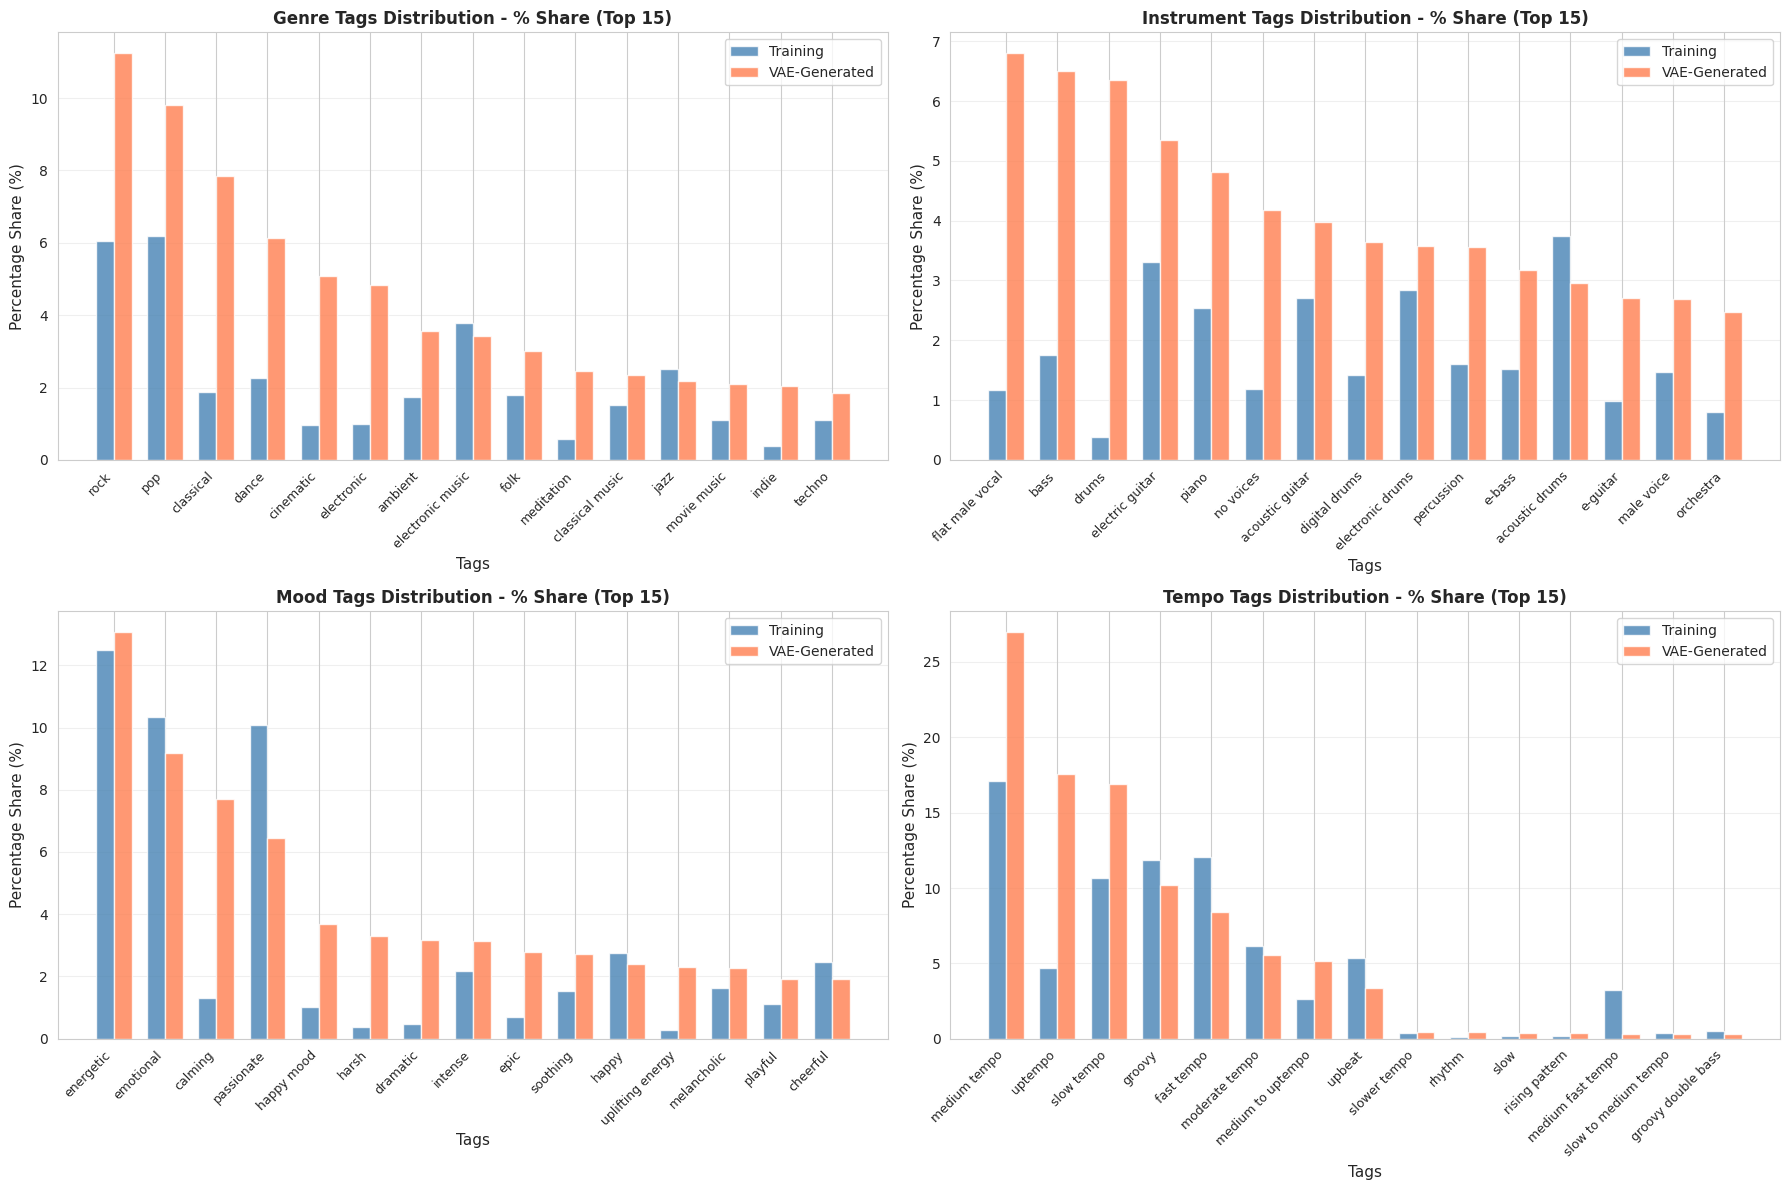

Individual tag distribution comparison plots created successfully (percentage shares)


In [51]:
# Create visualizations comparing tag distributions
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    comparison_df = tag_comparison_results[cat_name]
    
    # Select top 15 tags by training count for visibility
    top_tags = comparison_df.nlargest(15, 'VAE Count')
    
    x = np.arange(len(top_tags))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, top_tags['Training %'], width, label='Training', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, top_tags['VAE %'], width, label='VAE-Generated', color='coral', alpha=0.8)
    
    ax.set_xlabel('Tags', fontsize=11)
    ax.set_ylabel('Percentage Share (%)', fontsize=11)
    ax.set_title(f'{cat_name} Tags Distribution - % Share (Top 15)', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_tags['Tag'], rotation=45, ha='right', fontsize=9)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Individual tag distribution comparison plots created successfully (percentage shares)")


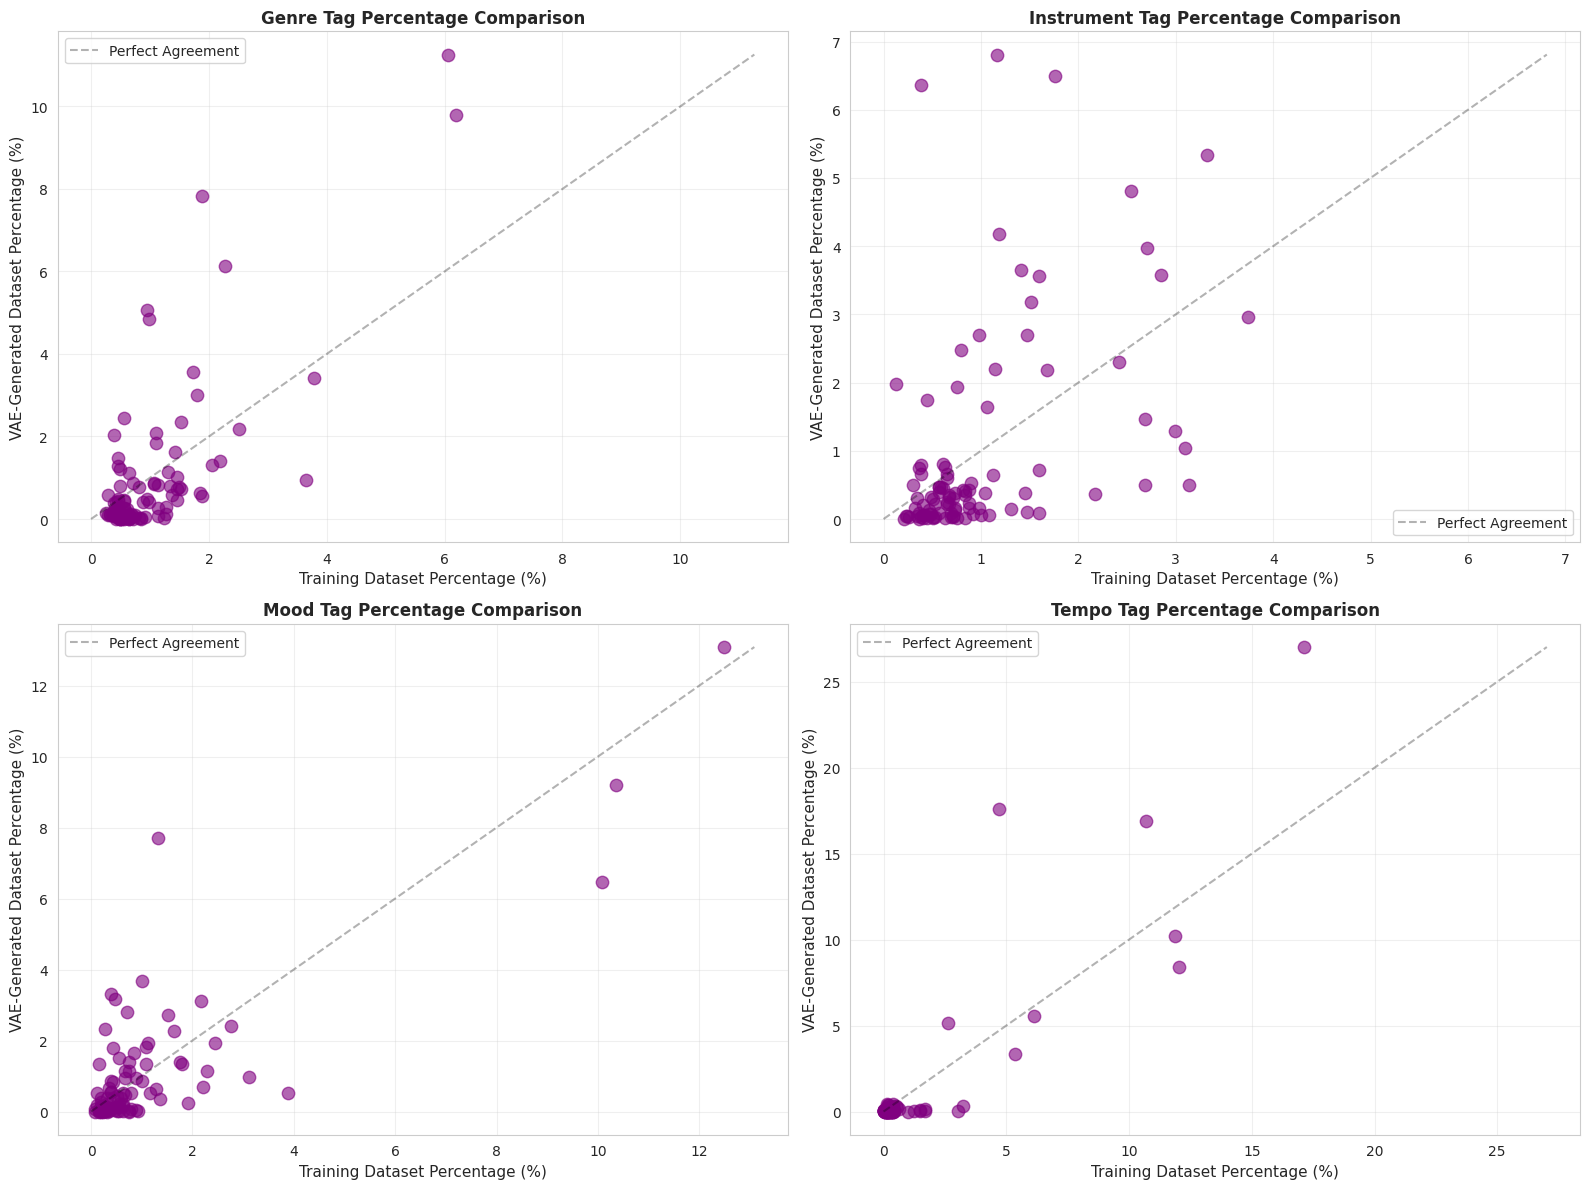


INDIVIDUAL TAG DISTRIBUTION STATISTICAL SUMMARY (Percentage Shares)
  Category  Mean Absolute % Diff  Max Absolute % Diff  Percentage Correlation  Unique Tags
     Genre              0.819963             5.957205                0.763630           97
Instrument              0.883052             5.968778                0.468955          100
      Mood              0.704904             6.389717                0.820980           92
     Tempo              0.698645            12.867480                0.887823           94

INTERPRETATION

The plots above compare how individual tags are distributed in training vs VAE-generated data (as % share):
- Points close to the diagonal line indicate similar tag percentages between datasets
- Percentage Correlation > 0.9 suggests excellent preservation of tag distribution patterns
- Mean Absolute % Difference indicates average deviation in tag percentages

If most points cluster near the diagonal, the VAE successfully preserves individual tag distribu

In [52]:
# Statistical comparison using percentage distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

statistical_summary = []

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    comparison_df = tag_comparison_results[cat_name]
    
    # Plot percentage scatter
    ax.scatter(comparison_df['Training %'], comparison_df['VAE %'], alpha=0.6, s=80, color='purple')
    
    # Add diagonal reference line (perfect agreement)
    max_pct = max(comparison_df['Training %'].max(), comparison_df['VAE %'].max())
    ax.plot([0, max_pct], [0, max_pct], 'k--', alpha=0.3, label='Perfect Agreement')
    
    ax.set_xlabel('Training Dataset Percentage (%)', fontsize=11)
    ax.set_ylabel('VAE-Generated Dataset Percentage (%)', fontsize=11)
    ax.set_title(f'{cat_name} Tag Percentage Comparison', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calculate statistics
    mae = (comparison_df['% Difference'].abs()).mean()
    max_diff = comparison_df['% Difference'].abs().max()
    corr = comparison_df['Training %'].corr(comparison_df['VAE %'])
    
    statistical_summary.append({
        'Category': cat_name,
        'Mean Absolute % Diff': mae,
        'Max Absolute % Diff': max_diff,
        'Percentage Correlation': corr,
        'Unique Tags': len(comparison_df)
    })

plt.tight_layout()
plt.show()

# Print statistical summary
summary_df = pd.DataFrame(statistical_summary)
print("\n" + "="*100)
print("INDIVIDUAL TAG DISTRIBUTION STATISTICAL SUMMARY (Percentage Shares)")
print("="*100)
print(summary_df.to_string(index=False))

# Calculate overall similarity
print("\n" + "="*100)
print("INTERPRETATION")
print("="*100)
print("\nThe plots above compare how individual tags are distributed in training vs VAE-generated data (as % share):")
print("- Points close to the diagonal line indicate similar tag percentages between datasets")
print("- Percentage Correlation > 0.9 suggests excellent preservation of tag distribution patterns")
print("- Mean Absolute % Difference indicates average deviation in tag percentages")
print("\nIf most points cluster near the diagonal, the VAE successfully preserves individual tag distributions.")


## Compare Category-wise Tag Counts


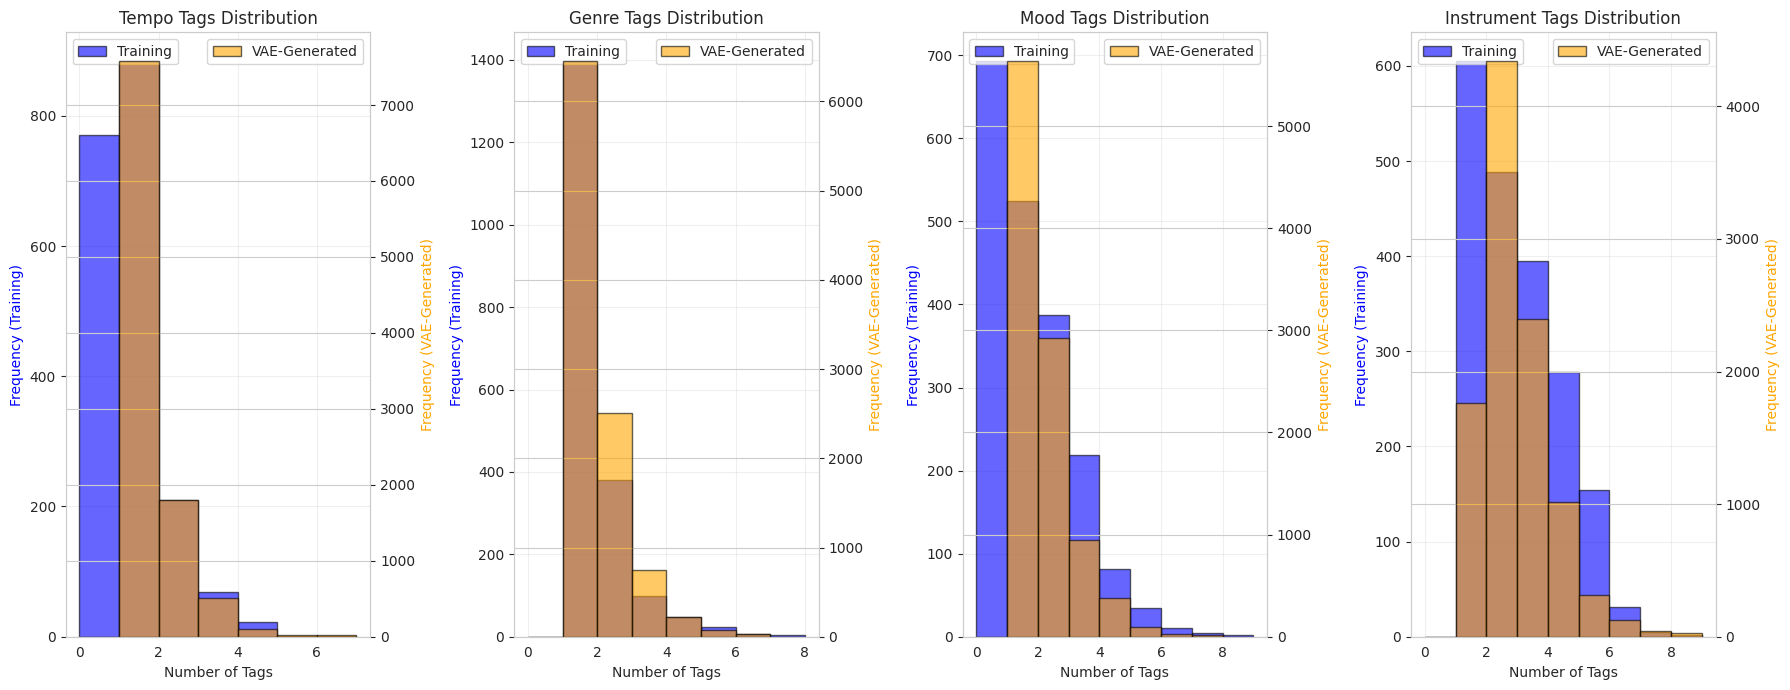

In [53]:

# Create side-by-side distribution plots
fig, axes = plt.subplots(1, len(tag_categories), figsize=(18, 7))
axes = axes.flatten()

for idx, (cat_name, col) in enumerate(tag_categories.items()):
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    train_counts = df_train[col].apply(len)
    vae_counts = df_vae_all[col].apply(len)
    
    # Create bins
    max_count = max(train_counts.max(), vae_counts.max())
    bins = np.arange(0, max_count + 2)
    
    # Plot histograms
    ax1.hist(train_counts, bins=bins, alpha=0.6, label='Training', color='blue', edgecolor='black')
    ax2.hist(vae_counts, bins=bins, alpha=0.6, label='VAE-Generated', color='orange', edgecolor='black')
    ax1.set_xlabel('Number of Tags')
    ax1.set_ylabel('Frequency (Training)', color='blue')
    ax2.set_ylabel('Frequency (VAE-Generated)', color='orange')
    ax1.set_title(f'{cat_name} Tags Distribution')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_12794/3126393489.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_12794/3126393489.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_12794/3126393489.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_12794/3126393489.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has 

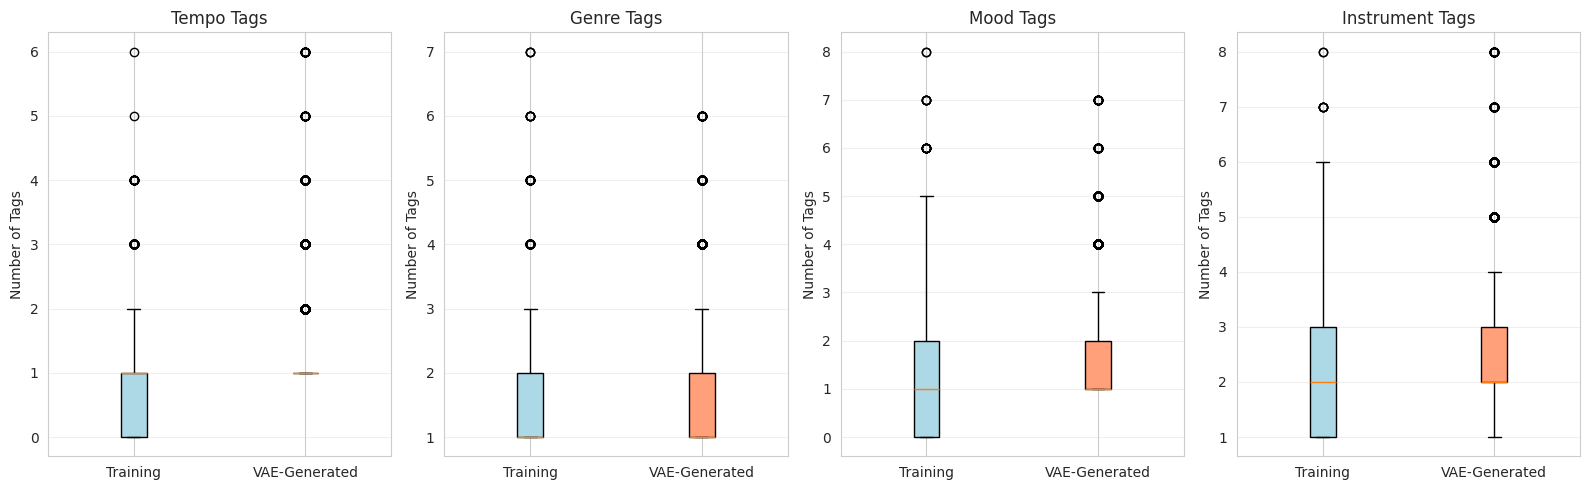

Box plot comparison created successfully


In [54]:

# Create box plots for detailed distribution comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for idx, (cat_name, col) in enumerate(tag_categories.items()):
    ax = axes[idx]
    
    train_counts = df_train[col].apply(len)
    vae_counts = df_vae_all[col].apply(len)
    
    data_to_plot = [train_counts, vae_counts]
    bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightsalmon']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel('Number of Tags')
    ax.set_title(f'{cat_name} Tags')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Box plot comparison created successfully")


## Analyze Tag Correlation Matrices


In [55]:

# Compute correlation matrices
train_tag_counts = pd.DataFrame({
    'Tempo': df_train['tempo_tags'].apply(len),
    'Genre': df_train['genre_tags'].apply(len),
    'Mood': df_train['mood_tags'].apply(len),
    'Instrument': df_train['instrument_tags'].apply(len)
})

vae_tag_counts = pd.DataFrame({
    'Tempo': df_vae_baseline['tempo_tags'].apply(len),
    'Genre': df_vae_baseline['genre_tags'].apply(len),
    'Mood': df_vae_baseline['mood_tags'].apply(len),
    'Instrument': df_vae_baseline['instrument_tags'].apply(len)
})

train_corr = train_tag_counts.corr()
vae_corr = vae_tag_counts.corr()

print("\n" + "="*100)
print("CORRELATION MATRIX - TRAINING DATASET")
print("="*100)
print(train_corr.round(3))

print("\n" + "="*100)
print("CORRELATION MATRIX - VAE-GENERATED DATASET")
print("="*100)
print(vae_corr.round(3))

print("\n" + "="*100)
print("CORRELATION DIFFERENCE (VAE - Training)")
print("="*100)
print((vae_corr - train_corr).round(3))



CORRELATION MATRIX - TRAINING DATASET
            Tempo  Genre   Mood  Instrument
Tempo       1.000  0.262  0.103       0.094
Genre       0.262  1.000  0.124       0.012
Mood        0.103  0.124  1.000      -0.028
Instrument  0.094  0.012 -0.028       1.000

CORRELATION MATRIX - VAE-GENERATED DATASET
            Tempo  Genre   Mood  Instrument
Tempo       1.000  0.143 -0.010       0.059
Genre       0.143  1.000  0.050      -0.012
Mood       -0.010  0.050  1.000      -0.009
Instrument  0.059 -0.012 -0.009       1.000

CORRELATION DIFFERENCE (VAE - Training)
            Tempo  Genre   Mood  Instrument
Tempo       0.000 -0.119 -0.113      -0.035
Genre      -0.119  0.000 -0.074      -0.023
Mood       -0.113 -0.074  0.000       0.019
Instrument -0.035 -0.023  0.019       0.000


## Visualize Distribution Differences


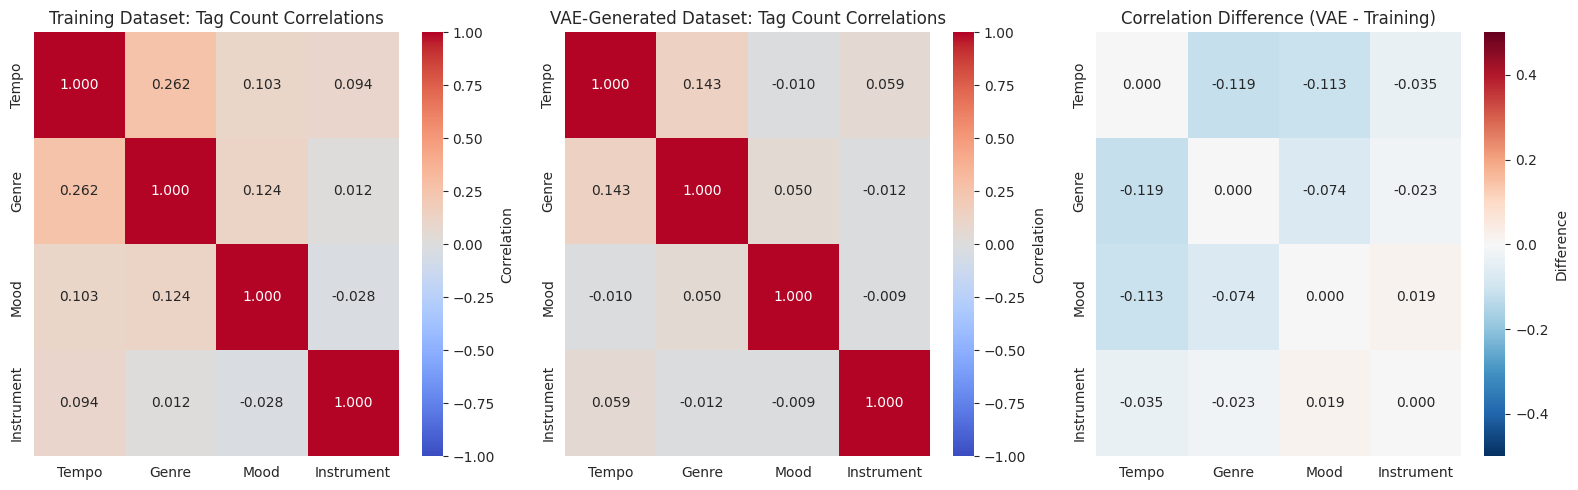

Correlation heatmaps created successfully


In [56]:

# Create correlation heatmaps side-by-side
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Training dataset correlation
sns.heatmap(train_corr, annot=True, fmt='.3f', cmap='coolwarm', vmin=-1, vmax=1, 
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Training Dataset: Tag Count Correlations')

# VAE-generated dataset correlation
sns.heatmap(vae_corr, annot=True, fmt='.3f', cmap='coolwarm', vmin=-1, vmax=1,
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('VAE-Generated Dataset: Tag Count Correlations')

# Difference
sns.heatmap(vae_corr - train_corr, annot=True, fmt='.3f', cmap='RdBu_r', vmin=-0.5, vmax=0.5,
            ax=axes[2], cbar_kws={'label': 'Difference'})
axes[2].set_title('Correlation Difference (VAE - Training)')

plt.tight_layout()
plt.show()

print("Correlation heatmaps created successfully")


## Temperature Analysis

Analyze how different temperature values in the VAE affect tag generation quality and distribution stability.

In [57]:
# Analyze individual tag occurrences across different temperatures
temperatures = sorted(df_vae['temperature'].unique())

print("\n" + "="*120)
print("TEMPERATURE ANALYSIS - INDIVIDUAL TAG OCCURRENCE PATTERNS")
print("="*120)
print(f"\nAvailable temperatures: {temperatures}")
print(f"Number of samples per temperature: {df_vae.groupby('temperature').size().to_dict()}")

# Collect tag occurrence patterns across temperatures
tag_temperature_patterns = {}

for cat_name, col_name in categories_to_compare:
    # Get training reference counts
    train_tags = get_all_tags(df_train, col_name)
    train_counter = Counter(train_tags)
    train_total = len(train_tags)
    
    # Collect per-tag statistics across temperatures
    tag_data = {}
    
    for temp in temperatures:
        df_vae_temp = df_vae[df_vae['temperature'] == temp].reset_index(drop=True)
        vae_tags = get_all_tags(df_vae_temp, col_name)
        vae_counter = Counter(vae_tags)
        vae_total = len(vae_tags)
        
        for tag in set(train_counter.keys()) | set(vae_counter.keys()):
            if tag not in tag_data:
                tag_data[tag] = {
                    'training_count': train_counter.get(tag, 0),
                    'training_pct': (train_counter.get(tag, 0) / train_total * 100) if train_total > 0 else 0,
                }
            
            vae_count = vae_counter.get(tag, 0)
            vae_pct = (vae_count / vae_total * 100) if vae_total > 0 else 0
            tag_data[tag][f'temp_{temp}_count'] = vae_count
            tag_data[tag][f'temp_{temp}_pct'] = vae_pct
    
    # Convert to DataFrame for analysis
    tag_df = pd.DataFrame(tag_data).T.reset_index()
    tag_df.columns = ['Tag'] + list(tag_df.columns[1:])
    
    tag_temperature_patterns[cat_name] = tag_df
    
    # Calculate correlations between temperatures and training
    print(f"\n{'='*100}")
    print(f"{cat_name.upper()} - INDIVIDUAL TAG ANALYSIS ACROSS TEMPERATURES")
    print(f"{'='*100}")
    
    # Show tags that vary most across temperatures
    temp_cols = [f'temp_{t}_pct' for t in temperatures]
    tag_df['temp_std'] = tag_df[temp_cols].std(axis=1)
    tag_df['temp_range'] = tag_df[temp_cols].max(axis=1) - tag_df[temp_cols].min(axis=1)
    tag_df['corr_with_training'] = tag_df[temp_cols].corrwith(tag_df['training_pct'], axis=0)
    
    # Sort by temperature variability
    high_variability = tag_df.nlargest(10, 'temp_range')[['Tag', 'training_pct'] + temp_cols + ['temp_range', 'temp_std']]
    print(f"\nTop 10 tags with HIGHEST variability across temperatures:")
    print(high_variability.to_string(index=False))
    
    # Sort by lowest variability (consistent across temperatures)
    low_variability = tag_df[tag_df['temp_range'] > 0].nsmallest(10, 'temp_range')[['Tag', 'training_pct'] + temp_cols + ['temp_range']]
    print(f"\nTop 10 tags with LOWEST variability across temperatures:")
    print(low_variability.to_string(index=False))


TEMPERATURE ANALYSIS - INDIVIDUAL TAG OCCURRENCE PATTERNS

Available temperatures: [0.5, 0.8, 1.0, 1.25, 1.5]
Number of samples per temperature: {0.5: 2036, 0.8: 2016, 1.0: 2005, 1.25: 2003, 1.5: 1979}

GENRE - INDIVIDUAL TAG ANALYSIS ACROSS TEMPERATURES

Top 10 tags with HIGHEST variability across temperatures:
             Tag  training_pct  temp_0.5_pct  temp_0.8_pct  temp_1.0_pct  temp_1.25_pct  temp_1.5_pct  temp_range  temp_std
             pop      6.194690     10.479922      9.007232      9.735974      10.201387      9.560293    1.472690  0.573018
       cinematic      0.955752      5.484819      4.963840      4.356436       5.810499      4.730180    1.454063  0.582308
       classical      1.876106      7.966046      7.856673      7.722772       8.352592      7.261825    1.090766  0.395797
     movie music      1.097345      1.860921      2.531229      2.541254       1.914823      1.598934    0.942320  0.425036
            rock      6.053097     11.720535     11.341223     10

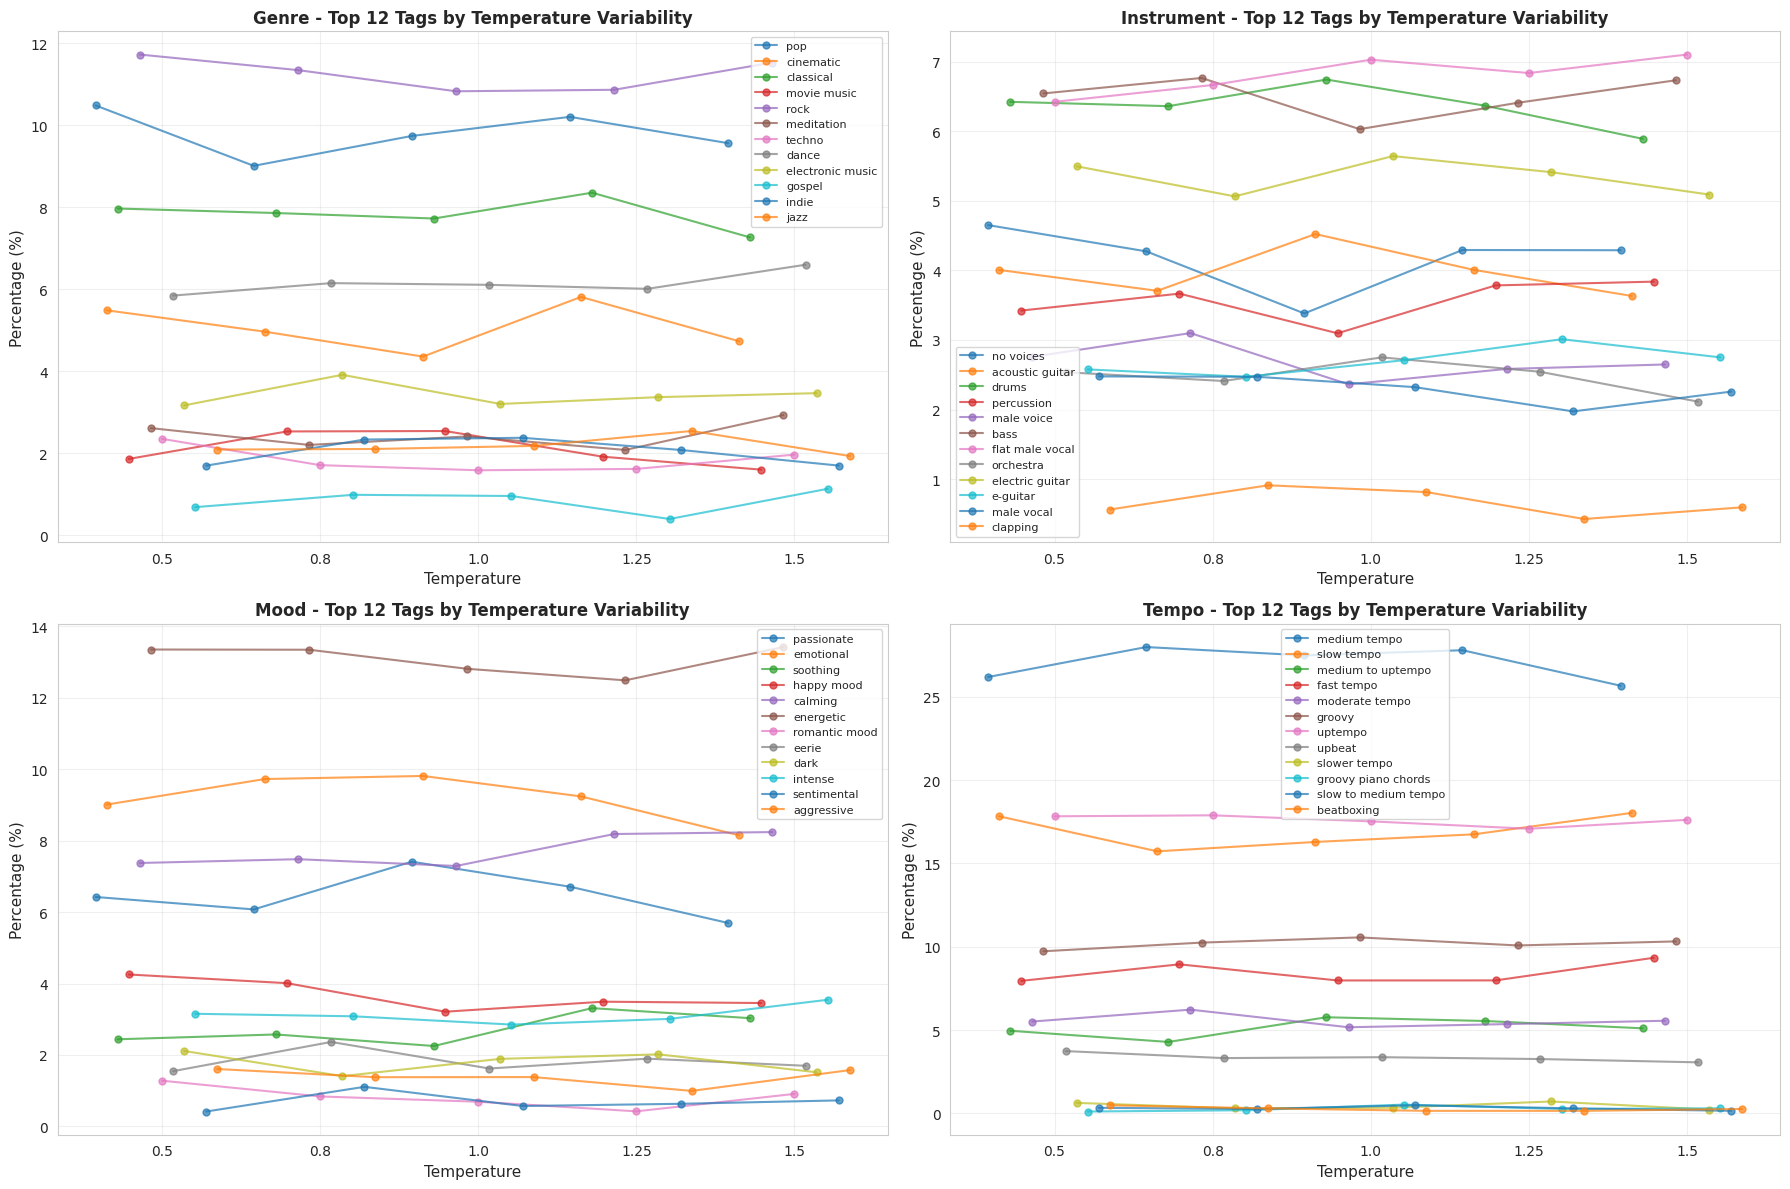

Tag occurrence patterns across temperatures visualization created successfully


In [58]:
# Create visualizations showing tag behavior across temperatures
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    tag_df = tag_temperature_patterns[cat_name]
    
    # Select top 12 tags by temperature variability
    top_variable_tags = tag_df.nlargest(12, 'temp_range')
    
    temp_cols = [f'temp_{t}_pct' for t in temperatures]
    x = np.arange(len(temperatures))
    width = 0.07
    
    # Plot training reference as a horizontal line
    for idx_tag, (_, row) in enumerate(top_variable_tags.iterrows()):
        offset = (idx_tag - len(top_variable_tags)/2) * width
        values = [row[col] for col in temp_cols]
        ax.plot(x + offset, values, marker='o', linewidth=1.5, markersize=5, label=row['Tag'], alpha=0.7)
    
    ax.set_xlabel('Temperature', fontsize=11)
    ax.set_ylabel('Percentage (%)', fontsize=11)
    ax.set_title(f'{cat_name} - Top 12 Tags by Temperature Variability', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{t}' for t in temperatures])
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Tag occurrence patterns across temperatures visualization created successfully")


In [59]:
# Analyze which tags favor lower vs higher temperatures
print("\n" + "="*120)
print("TAG PREFERENCE ANALYSIS - LOWER vs HIGHER TEMPERATURES")
print("="*120)

low_temp = temperatures[0]
high_temp = temperatures[-1]

for cat_name, _ in categories_to_compare:
    tag_df = tag_temperature_patterns[cat_name]
    
    # Calculate average percentage at low and high temperatures
    low_temp_col = f'temp_{low_temp}_pct'
    high_temp_col = f'temp_{high_temp}_pct'
    
    tag_df['low_temp_pct'] = tag_df[low_temp_col]
    tag_df['high_temp_pct'] = tag_df[high_temp_col]
    tag_df['temp_preference'] = tag_df['high_temp_pct'] - tag_df['low_temp_pct']
    
    print(f"\n{'='*100}")
    print(f"{cat_name.upper()} - TAG PREFERENCES ({low_temp} vs {high_temp})")
    print(f"{'='*100}")
    
    # Tags that appear more at HIGH temperature
    high_pref = tag_df.nlargest(10, 'temp_preference')[['Tag', 'training_pct', low_temp_col, high_temp_col, 'temp_preference']]
    print(f"\nTags that INCREASE at HIGHER temperature:")
    print(high_pref.to_string(index=False))
    
    # Tags that appear more at LOW temperature
    low_pref = tag_df.nsmallest(10, 'temp_preference')[['Tag', 'training_pct', low_temp_col, high_temp_col, 'temp_preference']]
    print(f"\nTags that DECREASE at HIGHER temperature (prefer LOWER temp):")
    print(low_pref.to_string(index=False))
    
    # Calculate correlation between each tag's pattern and training
    print(f"\nTag occurrence patterns vs Training dataset:")
    corr_summary = []
    for _, row in tag_df.iterrows():
        training_val = row['training_pct']
        temp_vals = [row[f'temp_{t}_pct'] for t in temperatures]
        if len(set(temp_vals)) > 0:  # Only if there's variation
            corr_summary.append({
                'Tag': row['Tag'],
                'Training %': training_val,
                'Mean VAE %': np.mean(temp_vals),
                '% Diff from Training': np.mean(temp_vals) - training_val,
                'Variability': np.std(temp_vals)
            })
    
    corr_df = pd.DataFrame(corr_summary).sort_values('% Diff from Training', ascending=False)
    print(f"\nTags with largest deviations from training:")
    print(corr_df.head(10).to_string(index=False))



TAG PREFERENCE ANALYSIS - LOWER vs HIGHER TEMPERATURES

GENRE - TAG PREFERENCES (0.5 vs 1.5)

Tags that INCREASE at HIGHER temperature:
             Tag  training_pct  temp_0.5_pct  temp_1.5_pct  temp_preference
           dance      2.265487      5.843944      6.595603         0.751659
          gospel      1.132743      0.685602      1.132578         0.446976
     dance music      3.646018      0.685602      1.099267         0.413665
 classical music      1.522124      2.122103      2.498334         0.376232
indian classical      0.460177      0.326477      0.666223         0.339745
      meditation      0.566372      2.611818      2.931379         0.319561
electronic music      3.787611      3.166830      3.464357         0.297527
movie soundtrack      1.522124      0.587659      0.832778         0.245119
         country      0.884956      0.261182      0.499667         0.238485
          horror      0.247788      0.032648      0.233178         0.200530

Tags that DECREASE at HIGH

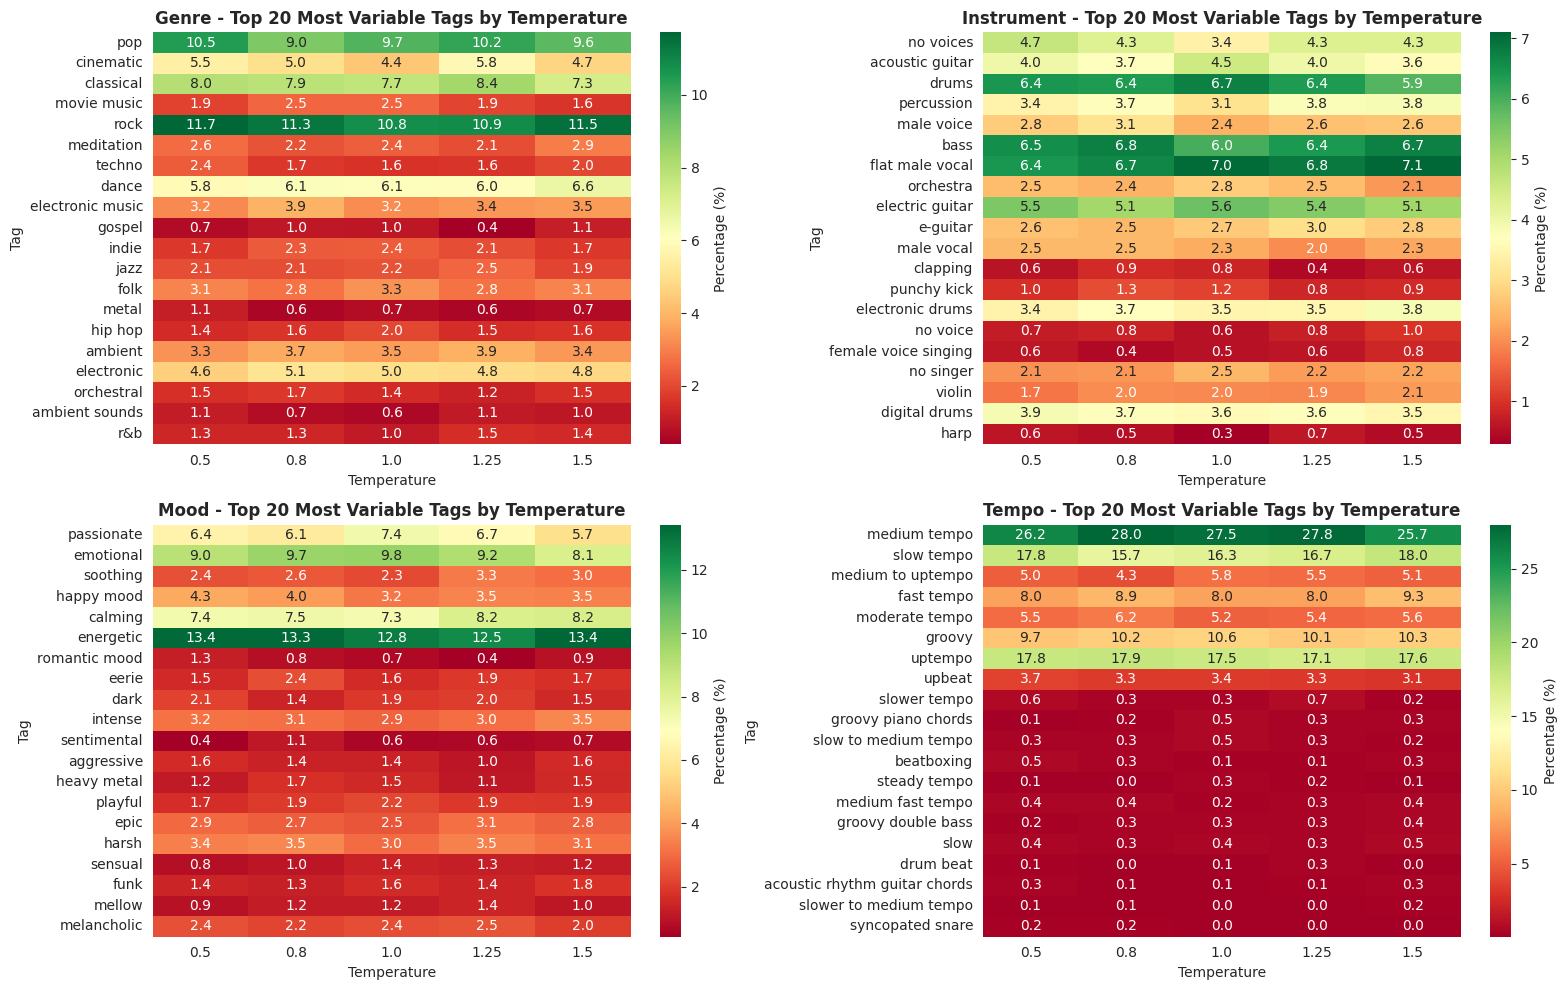

Tag occurrence heatmaps across temperatures created successfully


In [60]:
# Create heatmaps showing tag occurrence patterns across temperatures
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    tag_df = tag_temperature_patterns[cat_name]
    
    # Select top 20 most variable tags
    top_tags = tag_df.nlargest(20, 'temp_range')
    
    # Create matrix: rows = tags, columns = temperatures
    temp_cols = [f'temp_{t}_pct' for t in temperatures]
    heatmap_data = top_tags[['Tag'] + temp_cols].set_index('Tag')[temp_cols].values
    
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
                xticklabels=[f'{t}' for t in temperatures],
                yticklabels=top_tags['Tag'].values,
                cbar_kws={'label': 'Percentage (%)'})
    ax.set_title(f'{cat_name} - Top 20 Most Variable Tags by Temperature', fontsize=12, fontweight='bold')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Tag')

plt.tight_layout()
plt.show()

print("Tag occurrence heatmaps across temperatures created successfully")



POPULARITY ANALYSIS - MOST vs LEAST POPULAR TAGS ACROSS TEMPERATURES

GENRE - POPULARITY DYNAMICS

Most Popular Tags in Training (% change from low to high temp):
  pop                 :   6.19% (train) →  10.48% (0.5°) →   9.56% (1.5°) | Change: -0.92%
  rock                :   6.05% (train) →  11.72% (0.5°) →  11.53% (1.5°) | Change: -0.19%
  electronic music    :   3.79% (train) →   3.17% (0.5°) →   3.46% (1.5°) | Change: +0.30%
  dance music         :   3.65% (train) →   0.69% (0.5°) →   1.10% (1.5°) | Change: +0.41%
  jazz                :   2.51% (train) →   2.09% (0.5°) →   1.93% (1.5°) | Change: -0.16%

Least Popular Tags in Training (% change from low to high temp):
  arabic music        :   0.32% (train) →   0.10% (0.5°) →   0.07% (1.5°) | Change: -0.03%
  punk rock           :   0.32% (train) →   0.26% (0.5°) →   0.03% (1.5°) | Change: -0.23%
  folk rock           :   0.28% (train) →   0.03% (0.5°) →   0.13% (1.5°) | Change: +0.10%
  jazzy               :   0.28% (train) → 

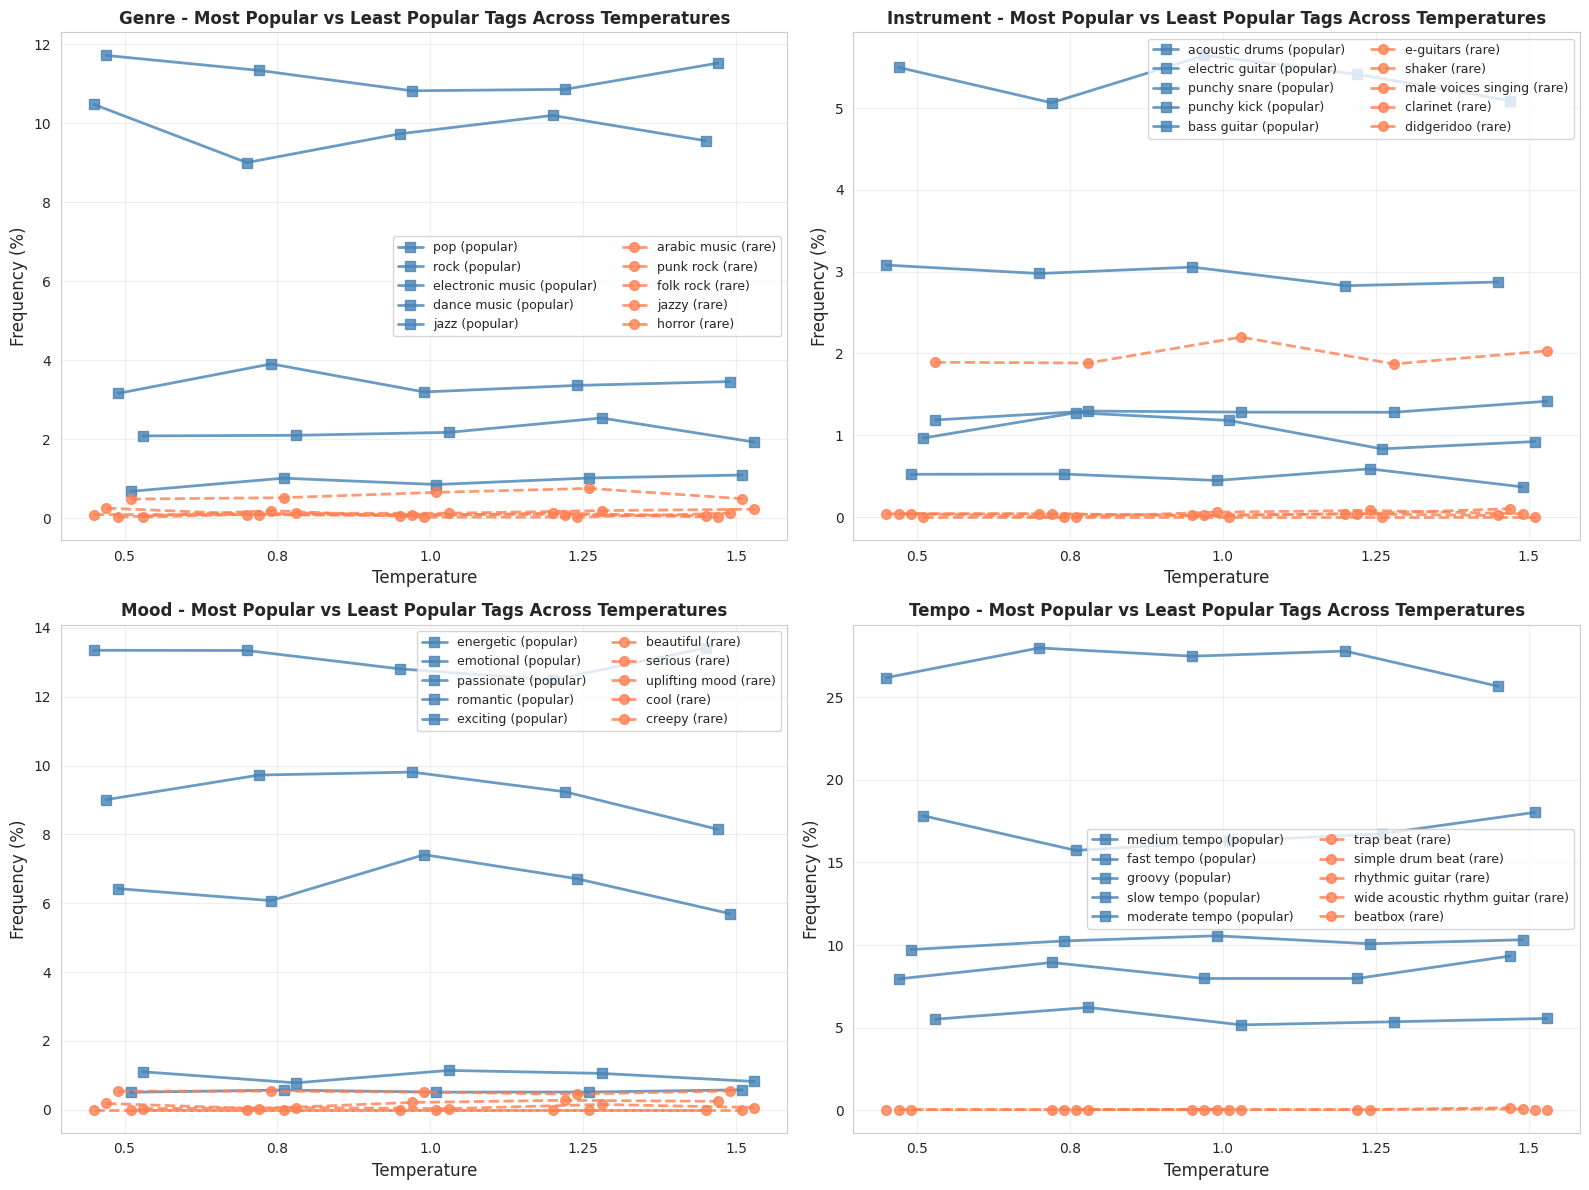


Popularity dynamics across temperatures visualization created successfully


In [61]:
# Analyze how popular vs unpopular tags change with temperature
print("\n" + "="*120)
print("POPULARITY ANALYSIS - MOST vs LEAST POPULAR TAGS ACROSS TEMPERATURES")
print("="*120)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    tag_df = tag_temperature_patterns[cat_name]
    
    # Identify most and least popular tags in training dataset
    tag_df_sorted = tag_df.sort_values('training_pct', ascending=False)
    
    num_tags = 5
    most_popular = tag_df_sorted.head(num_tags)
    least_popular = tag_df_sorted.tail(num_tags)
    
    # Collect temperature values
    temp_cols = [f'temp_{t}_pct' for t in temperatures]
    x = np.arange(len(temperatures))
    width = 0.08
    
    # Plot most popular tags
    for idx_tag, (_, row) in enumerate(most_popular.iterrows()):
        offset = (idx_tag - num_tags/2) * width
        values = [row[col] for col in temp_cols]
        ax.plot(x + offset, values, marker='s', linewidth=2, markersize=7, 
                label=f"{row['Tag']} (popular)", alpha=0.8, color='steelblue')
    
    # Plot least popular tags
    for idx_tag, (_, row) in enumerate(least_popular.iterrows()):
        offset = (idx_tag - num_tags/2) * width
        values = [row[col] for col in temp_cols]
        ax.plot(x + offset, values, marker='o', linewidth=2, markersize=7, 
                label=f"{row['Tag']} (rare)", alpha=0.8, color='coral', linestyle='--')
    
    ax.set_xlabel('Temperature', fontsize=12)
    ax.set_ylabel('Frequency (%)', fontsize=12)
    ax.set_title(f'{cat_name} - Most Popular vs Least Popular Tags Across Temperatures', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{t}' for t in temperatures])
    ax.legend(fontsize=9, loc='best', ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Print analysis
    print(f"\n{'='*100}")
    print(f"{cat_name.upper()} - POPULARITY DYNAMICS")
    print(f"{'='*100}")
    
    print(f"\nMost Popular Tags in Training (% change from low to high temp):")
    for _, row in most_popular.iterrows():
        low_pct = row[f'temp_{low_temp}_pct']
        high_pct = row[f'temp_{high_temp}_pct']
        change = high_pct - low_pct
        print(f"  {row['Tag']:20s}: {row['training_pct']:6.2f}% (train) → {low_pct:6.2f}% ({low_temp}°) → {high_pct:6.2f}% ({high_temp}°) | Change: {change:+.2f}%")
    
    print(f"\nLeast Popular Tags in Training (% change from low to high temp):")
    for _, row in least_popular.iterrows():
        low_pct = row[f'temp_{low_temp}_pct']
        high_pct = row[f'temp_{high_temp}_pct']
        change = high_pct - low_pct
        print(f"  {row['Tag']:20s}: {row['training_pct']:6.2f}% (train) → {low_pct:6.2f}% ({low_temp}°) → {high_pct:6.2f}% ({high_temp}°) | Change: {change:+.2f}%")

plt.tight_layout()
plt.show()

print("\nPopularity dynamics across temperatures visualization created successfully")
